#a

We used 'Unified Memory' in our code which you can learn about [here](https://developer.nvidia.com/blog/even-easier-introduction-cuda/).

In [48]:
%%writefile jacobi.cu

#include <iostream>
#include <math.h>
#include <sys/time.h>
#include <time.h>
#include <cuda_runtime.h>
#include <stdio.h>

#define n 100
#define m 100
#define tol 0.001

using namespace std;

double diffmax;

// Kernel function
__global__
void updateTemp(double **t, double **tnew, double **diff)
{
  int j = blockIdx.x * blockDim.x + threadIdx.x;
  int i = blockIdx.y * blockDim.y + threadIdx.y;
  
  //printf("i, j: %d, %d\n", i, j);
  //printf("i: %d %d %d\n", blockDim.x, blockIdx.x, threadIdx.x);
  //printf("j: %d %d %d\n=============\n", blockDim.y, blockIdx.y, threadIdx.y);
  
  if (1 <= i && i <= m && 1 <= j && j <= n) {
    tnew[i][j] = (t[i - 1][j] + t[i + 1][j] + t[i][j - 1] + t[i][j + 1]) / 4.0;
    diff[i][j] = fabs(tnew[i][j] - t[i][j]);
    
    // copy new to old temperatures
    t[i][j] = tnew[i][j];
  }
}

int main(void)
{
  struct timeval startTime, stopTime;
  long totalTime;
  double **t, **tnew, **diff;

  // Allocate Unified Memory – accessible from CPU or GPU
  cudaMallocManaged(&t, (m + 2)*sizeof(double*));
  for (int i = 0; i < m + 2; ++i)
    cudaMallocManaged(&t[i], (n + 2)*sizeof(double));
  cudaMallocManaged(&tnew, (m + 2)*sizeof(double*));
  for (int i = 0; i < m + 2; ++i)
    cudaMallocManaged(&tnew[i], (n + 2)*sizeof(double));
  cudaMallocManaged(&diff, (m + 2)*sizeof(double*));
  for (int i = 0; i < m + 2; ++i)
    cudaMallocManaged(&diff[i], (n + 2)*sizeof(double));

  for (int z = 0; z < 11; ++z) {
    gettimeofday(&startTime, NULL);

    // initialize x and y arrays on the host
    for (int i = 0; i < m + 2; ++i)
      for (int j = 0; j < n + 2; ++j)
        t[i][j] = 30.0;
    // fix boundary conditions
    for (int i = 1; i <= m; ++i) {
      t[i][0] = 10.0;
      t[i][n + 1] = 140.0;
    }
    for (int j = 1; j <= n; ++j) {
      t[0][j] = 20.0;
      t[m + 1][j] = 100.0;
    }

    // main loop
    int iter = 0;
    diffmax = 1000000.0;
    
    int block_size = 25;
    // Setup the execution configuration
    dim3 dimGrid(m/block_size, n/block_size);
    dim3 dimBlock(block_size, block_size);
    
    while (diffmax > tol) {
      ++iter;

      // update temperature for next iteration
      // Run kernel on 1M elements on the GPU
      updateTemp<<<dimGrid, dimBlock>>>(t, tnew, diff);

      // Wait for GPU to finish before accessing on host
      cudaDeviceSynchronize();

      // work out maximum difference between old and new temperatures
      diffmax = 0.0;
      for (int i = 1; i <= m; ++i)
        for (int j = 1; j <= n; ++j)
          if (diff[i][j] > diffmax)
            diffmax = diff[i][j];
    }

    gettimeofday(&stopTime, NULL);
    totalTime = (stopTime.tv_sec * 1000000 + stopTime.tv_usec) -
                (startTime.tv_sec * 1000000 + startTime.tv_usec);

    printf("%ld\n", totalTime);
  }
  // Free memory
  for (int i = 0; i < m + 2; ++i) {
    cudaFree(t[i]);
    cudaFree(tnew[i]);
    cudaFree(diff[i]);
  }
  cudaFree(t);
  cudaFree(tnew);
  cudaFree(diff);

  return 0;
}

Overwriting jacobi.cu


In [49]:
%%shell

nvcc jacobi.cu -o jacobi_cuda
nvprof ./jacobi_cuda

==1495== NVPROF is profiling process 1495, command: ./jacobi_cuda
1844340
2361654
2059752
2211834
2504099
4408898
3162629
2461164
1996952
1971743
1910846
==1495== Profiling application: ./jacobi_cuda
==1495== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  7.62332s     40315  189.09us  11.392us  19.188ms  updateTemp(double**, double**, double**)
      API calls:   89.39%  8.59823s     40315  213.28us  3.7590us  27.502ms  cudaDeviceSynchronize
                    7.13%  686.25ms     40315  17.022us  3.6540us  11.960ms  cudaLaunchKernel
                    3.43%  330.37ms       309  1.0692ms  2.6270us  329.03ms  cudaMallocManaged
                    0.04%  3.7375ms       309  12.095us  8.7030us  166.29us  cudaFree
                    0.00%  345.65us         1  345.65us  345.65us  345.65us  cuDeviceTotalMem
                    0.00%  150.28us       101  1.4870us     142ns  63.627us  cuDeviceGetAttribute
       

#b

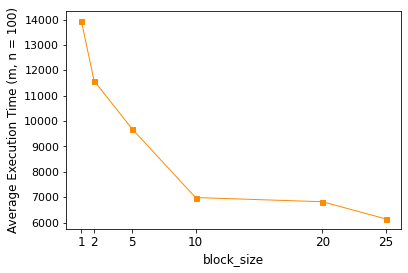

In [51]:
import matplotlib.pyplot as plt

#           Type  Time(%)      Time     Calls       Avg       Min       Max  Name
#1 GPU activities:  100.00%  13.9347s     41577  335.15us  81.022us  35.722ms  updateTemp(double**, double**, double**)
#2 GPU activities:  100.00%  11.5856s     40487  286.16us  35.872us  11.004ms  updateTemp(double**, double**, double**)
#5 GPU activities:  100.00%  9.69065s     40315  240.37us  17.919us  9.3763ms  updateTemp(double**, double**, double**)
#10GPU activities:  100.00%  6.98655s     40315  173.30us  12.447us  8.9276ms  updateTemp(double**, double**, double**)
#20GPU activities:  100.00%  6.82180s     40315  169.21us  10.560us  9.3243ms  updateTemp(double**, double**, double**)
#25GPU activities:  100.00%  6.14425s     40315  152.41us  10.688us  10.913ms  updateTemp(double**, double**, double**)
#

first = [13.9347*1000, 11.5856*1000, 9.69065*1000, 6.98655*1000, 6.82180*1000, 6.14425*1000]

x = [1, 2, 5, 10, 20, 25]

# Plot lines with different marker sizes
plt.plot(x, first, marker='s', ms=5, linewidth=1, color='darkorange') # square

plt.ylabel('Average Execution Time (m, n = 100)',fontsize=12)

plt.xlabel('block_size',fontsize=12)
plt.yticks(fontsize=11)

plt.xticks([1, 2, 5, 10, 20, 25], fontsize=12)
plt.show()

#c

In OpenMP implementation we had 658000-676000 milli seconds of average execution time. Using CUDA numbers are much decreased (14000-6000 ms). The differance is huge.

#d

We explained two reasons for our results on OpenMP implementation.

Considering those problems with OpenMP, CUDA (using GPUs) solves the problems we had and significantly reduces execution time.

On the other hand using bigger block_size gives us more parallelism doing so reduces execution time a lot.